# Doc 6.3 - Data augmentation com cv2

In [1]:
#Imports padrão para o desenvolvimento da rede e visualização do dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau #Interessante esse aqui - redução do LR se a validation n melhorar
from tensorflow.keras.applications import DenseNet121
from keras.applications import VGG16
from keras.models import Model

#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil
from pathlib import Path
import imagesize
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'Frequencia de categoria one hot no dataset de teste')

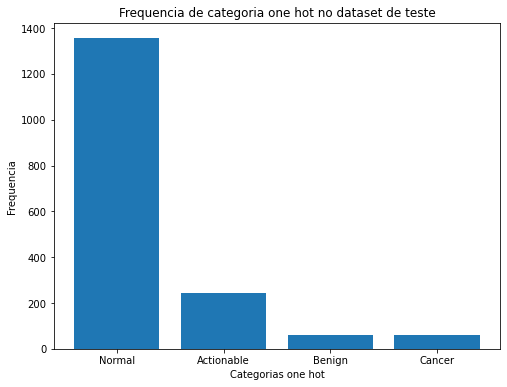

In [2]:
labels = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-labels-test-PHASE-2.csv") #Arquivo dos diagnosticos

one_hot_sum = labels[['Normal', 'Actionable', 'Benign', 'Cancer']].sum()

plt.figure(figsize=(8, 6))

plt.bar(['Normal', 'Actionable', 'Benign', 'Cancer'], one_hot_sum)

plt.xlabel('Categorias one hot')
plt.ylabel('Frequencia')
plt.title('Frequencia de categoria one hot no dataset de teste')

In [3]:
original_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\test"
balanced_folder = r"data"

counts = {
    "normal": 60,
    "actionable": 60,
    "benign": 61,  
    "cancer": 60   
}

for category, count in counts.items():
    #Pega as classes
    category_images = os.listdir(os.path.join(original_folder, category))
    #Pega imagens aleatórias de cada classe
    random_images = random.sample(category_images, count)
    #Cria o folder da classe
    os.makedirs(os.path.join(balanced_folder, category), exist_ok=True)
    #Joga as imagens da classe no seu respectivo folder
    for image in random_images:
        shutil.copy(os.path.join(original_folder, category, image), os.path.join(balanced_folder, category))

In [4]:
def resize_images(folder_path, target_size):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"): 
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                if image.size != target_size:
                    resized_image = image.resize(target_size, Image.ANTIALIAS)
                    resized_image.save(file_path)
                    

folder_path = r"D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6.3 - Data augmentation diferente com maior balanceamento\data"
target_size = (1890, 2457) #Vamos primeiro dar o resize nas imagens que não têm essas dimensões.
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_7928\3946010822.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [5]:
#Agora damos um resize de 4 vezes menor.
target_size = (1890//4, 2457//4)
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_7928\3946010822.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [6]:
input_folder = 'data' 
output_folder = 'split_data' 

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None) #Train/val/test

Copying files: 241 files [00:01, 217.17 files/s]


In [7]:
def augment_image(image, image_name):
    #Fazer o mirroring da imagem
    mirrored_v = cv2.flip(image, 0)
    mirrored_h = cv2.flip(image, 1)
    mirrored_both = cv2.flip(image, -1)

    #Ajustar brilho
    brightness = np.random.randint(-50, 50)
    brightened = np.clip(image + brightness, 0, 255).astype(np.uint8)

    #Ajustar contraste
    contrast = np.random.uniform(0.5, 1.5)
    mean = np.mean(image)
    contrasted = np.clip((image - mean) * contrast + mean, 0, 255).astype(np.uint8)

    #Adiciona ruído
    noise = np.random.normal(0, 10, image.shape)
    noisy = np.clip(image + noise, 0, 255).astype(np.uint8)

    augmented_images = {
        'mirrored_v': mirrored_v,
        'mirrored_h': mirrored_h,
        'mirrored_both': mirrored_both,
        'brightened': brightened,
        'contrasted': contrasted,
        'noisy': noisy
    }

    return augmented_images

In [8]:
train_folder = 'split_data/train'

#Vai fazer um loop em todas as classes
for class_folder in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_folder)
    if os.path.isdir(class_path):
        #Loop em cada imagem do folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image = cv2.imread(image_path)

                #Aplica a augmentation
                augmented_images = augment_image(image, image_name)

                #Salva a imagem com o nome da aoperacao feita
                for operation, augmented_image in augmented_images.items():
                    save_name = f'{os.path.splitext(image_name)[0]}_{operation}.png'
                    save_path = os.path.join(class_path, save_name)
                    cv2.imwrite(save_path, augmented_image)

In [9]:
train_dir = 'split_data/train' 
val_dir = 'split_data/val' 
test_dir = 'split_data/test' 

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(1890//4, 2457//4),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(1890//4, 2457//4),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(1890//4, 2457//4),
    batch_size=32,
    class_mode='categorical'
)

Found 1176 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 37 images belonging to 4 classes.


In [11]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)


model_densenet = Model(inputs=base_model.input, outputs=predictions)

model_densenet.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_densenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 472, 614, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 478, 620, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 236, 307, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 236, 307, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 236, 307, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 238, 309, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 118, 154, 64)      │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 118, 154, 64)      │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 118, 154, 64)      │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 118, 154, 128)     │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 118, 154, 128)     │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 118, 154, 128)     │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 118, 154, 32)      │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 118, 154, 96)      │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 41,903,300 (159.85 MB)

 Trainable params: 34,865,796 (133.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [12]:
history_densenet = model_densenet.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 535s 14s/step - accuracy: 0.2763 - loss: 4.0804 - val_accuracy: 0.3333 - val_loss: 1.4587
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 505s 13s/step - accuracy: 0.5661 - loss: 1.0679 - val_accuracy: 0.3611 - val_loss: 1.4434
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 517s 13s/step - accuracy: 0.7576 - loss: 0.7868 - val_accuracy: 0.3611 - val_loss: 1.3171
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 518s 14s/step - accuracy: 0.8434 - loss: 0.6102 - val_accuracy: 0.3333 - val_loss: 1.7612
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 520s 13s/step - accuracy: 0.8876 - loss: 0.4539 - val_accuracy: 0.3333 - val_loss: 1.5757
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 530s 14s/step - accuracy: 0.9341 - loss: 0.3520 - val_accuracy: 0.3056 - val_loss: 1.8857
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 532s 13s/step - accuracy: 0.9790 - loss: 0.2555 - val_accuracy: 0.3333 - val_loss: 1.8429
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 522s 14s/step - accuracy: 0.9832 - loss: 0.2142 - val_accuracy: 0.3056 - val_

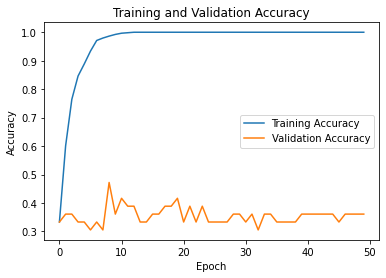

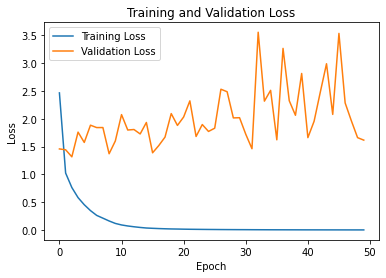

In [13]:
#Analise da precisao do treinamento e validacao
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
test_loss, test_accuracy = model_densenet.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1706 - loss: 3.5987
Test Accuracy: 16.22%
Test Loss: 3.7664


In [15]:
predictions = model_densenet.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step


array([2, 1, 0, 2, 2, 2, 0, 3, 1, 0, 3, 0, 2, 2, 1, 3, 0, 2, 3, 2, 1, 1,
       3, 1, 2, 2, 3, 0, 1, 3, 2, 0, 3, 0, 3, 3, 2], dtype=int64)

In [16]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [17]:
#Pega os indices que foram classificados errados (i.e. vai pegar o indice dos dois arrays que estao diferentes EM VALOR)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_indices

array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20,
       21, 22, 23, 26, 27, 28, 30, 31, 33, 36], dtype=int64)

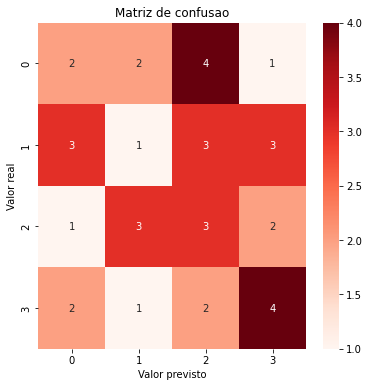

In [18]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [19]:
model_densenet.save("model_densenet3.keras")